<a href="https://colab.research.google.com/github/cristina-ramos/class_NLP/blob/main/Assignments/text_classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from keras.layers import LSTM, Bidirectional, Masking
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True )

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete64UHAQ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete64UHAQ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete64UHAQ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text:', example.numpy())
  print('label:', label.numpy())

text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label: 0


In [ ]:
buffer_size = 10000
batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts:', example.numpy()[:3])
  print()
  print('labels:', label.numpy()[:3])

texts: [b'Okay, here\'s what I think about Jack Frost. I looked at the morphing box for the VHS tape and I thought to myself, this looks interesting. I rent it and I take it home. Boy was I right, it is interesting. They put serial killer\'s spirits in dreams, in walking corpses and inside every day machines. But this has got to be the most unique place to put the spirit of a serial killer. Inside the body of a snowman. I liked all the friendly snowman images littering the landscape, the pot holder, the snow globe, etc. I like the actor who played Jack, he put some fun into a killer really not seen since FREDDY KRUGGER. That\'s right, I said it. FREDDY KRUGGER. It\'s that level of "cool". I wish some of the puppet effects were better, the mouth movements could have matched better. But I chalk that up to a small budget. The cast does a great job, there are some great one liners and scares to make any hardcore horror fan jump. All and all, a great story, good effects, great dialog and a 

In [ ]:
vocab_size = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)

encoder.adapt(train_dataset.map(lambda text, label: text))
#this kept producing a runtime error, had to reload the dataset again for it to work

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[869,   1,  49, ...,   0,   0,   0],
       [ 10,   1,   6, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0]])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_state=False, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])


In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1158s 3s/step - loss: 0.6251 - accuracy: 0.5860 - val_loss: 0.4507 - val_accuracy: 0.7964
Epoch 2/10
391/391 [==============================] - 1157s 3s/step - loss: 0.3859 - accuracy: 0.8308 - val_loss: 0.3467 - val_accuracy: 0.8495
Epoch 3/10
391/391 [==============================] - 1150s 3s/step - loss: 0.3342 - accuracy: 0.8547 - val_loss: 0.3368 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 1143s 3s/step - loss: 0.3159 - accuracy: 0.8629 - val_loss: 0.3255 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 1148s 3s/step - loss: 0.3085 - accuracy: 0.8680 - val_loss: 0.3236 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 1152s 3s/step - loss: 0.3035 - accuracy: 0.8698 - val_loss: 0.3315 - val_accuracy: 0.8380
Epoch 7/10
391/391 [==============================] - 1150s 3s/step - loss: 0.3021 - accuracy: 0.8709 - val_loss: 0.3214 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Acc: {}'.format(test_acc))

391/391 [==============================] - 246s 630ms/step - loss: 0.3274 - accuracy: 0.8586
Test Loss: 0.3273654282093048
Test Acc: 0.8586400151252747


(0.0, 0.7110658288002014)

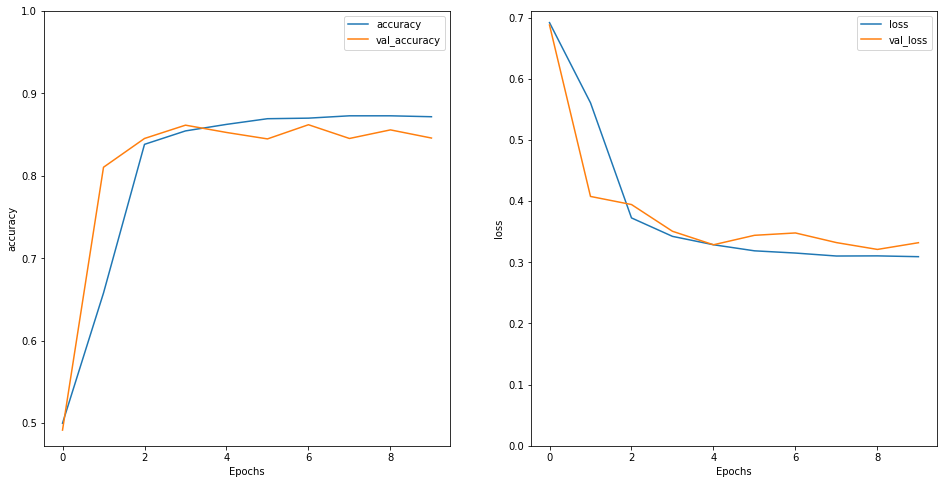

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)